# Edge Detection with Neural Networks

In this notebook we present our approach on detecting edges with neural networks. We are using keras deep learning library with tensorflow backend for easy and high-level implementation of the neural network. 

We make our experiments on `BSDS500` segmentation dataset strictly following the dataset division (i.e. 200 images for training, 100 for validation, and 200 for testing). We generated `.jpg` image labels out of segmentation MatLab files provided in github-mirror of the dataset and compared these images with those predicted by the network.

Our approach can be summarised as an attempt of approximating first order derivative approaches (filters) for edge detection. The architecture of the network can be seen visually at the buttom of this notebook. We try to obtain both filters in X and Y directions denoted by `Gx` and `Gy` and combine them with `sqrt( Gx^2 + Gy^2 )`. The result is then normalized to have values `[0...1]`.

We also explore and analyse the filters and weights that the network learned during training. And see weather it was really an approximation of one of the first order derivative based algorithm filters or not.

In [1]:
import keras

from scipy.ndimage.filters import gaussian_filter
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


### Cusom layers

To be able to combine Gx and Gy we needed a custom layer that merged these layers with `sqrt( Gx^2 + Gy^2 )` operation. The first class `CombineGradients` is dedicated for that task.

The next operation needed was to normalize the output to the range `[0...1]`. `Normalize` class is doing that operation by reducing minimum for each output image, then dividing it by the resulting maximum of an image.

In [2]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class CombineGradients(Layer):
    """
    sqrt( Gx^2 + Gy^2 )
    """

    def call(self, inputs, **kwargs):
        Gx = inputs[0]
        Gy = inputs[1]
        grad = K.sqrt( Gx**2 + Gy**2 )
        return grad

    def compute_output_shape(self, input_shape):
        return input_shape[0]


class Normalize(Layer):
    """
    Normalize output of inputs to the range [0...1]
    """
    
    def call(self, inputs, **kwargs):
        res = K.identity(inputs[:, :, :, 0])
        
        minimum = K.min(res, axis=1)
        minimum = K.min(minimum, axis=1)
        minimum = K.repeat_elements(minimum, 256, axis=0)
        minimum = K.reshape(minimum, shape=(K.shape(res)[0], 256))
        minimum = K.repeat(minimum, 256)
        res -= minimum

        maximum = K.max(res, axis=1)
        maximum = K.max(maximum, axis=1)
        maximum = K.repeat_elements(maximum, 256, axis=0)
        maximum = K.reshape(maximum, shape=(K.shape(res)[0], 256))
        maximum = K.repeat(maximum, 256)
        res *= K.constant(1.) / maximum
        return res
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

### Model construction

The input layer is receiving a grayscale image.

Both `Gx` and `Gy` are 2D Convolutions applied on the input (similar to Sobel/Prewitt/Robert's operators)

After applying convolutional filters, they are merged together to form the resulting gradient and normalized later on.

Model is optimized with `Adam` optimzer using loss `binary_crossentropy`

In [3]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.models import Model

input_layer = Input(shape=(None, None, 1), name='input')
Gx = Conv2D(filters=1, kernel_size=(3, 3), padding='same', name='Gx')(input_layer)
Gy = Conv2D(filters=1, kernel_size=(3, 3), padding='same', name='Gy')(input_layer)
grad = CombineGradients(name='G')([Gx, Gy])
out = Normalize(name='output')(grad)

model = Model(inputs=input_layer, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, None, 1) 0                                            
____________________________________________________________________________________________________
Gx (Conv2D)                      (None, None, None, 1) 10          input[0][0]                      
____________________________________________________________________________________________________
Gy (Conv2D)                      (None, None, None, 1) 10          input[0][0]                      
____________________________________________________________________________________________________
G (CombineGradients)             (None, None, None, 1) 0           Gx[0][0]                         
                                                                   Gy[0][0]                

### Helper functions for thesholding and obtaining data

In [4]:
from skimage.filters import threshold_otsu, threshold_local

def apply_threshold(input_image, threshold, high_value, low_value):
    assert input_image.shape == threshold.shape
    diff = input_image - threshold
    
    result = np.ones(shape=input_image.shape) * high_value
    low_indices = diff[:,:] < 0
    result[low_indices] = low_value
    return result

def global_otsu_thresholding(input_image, high_value=1, low_value=0):
    global_thresh = threshold_otsu(input_image)
    return apply_threshold(input_image, 
                           np.ones(shape=input_image.shape) * global_thresh, 
                           high_value, 
                           low_value)

In [5]:
def get_smple(path, scale, reshape):
    img = misc.imread(path, mode='L')
    img = misc.imresize(img, size=(256, 256))
    img = np.array(img, dtype=np.float32)
    if reshape:
        img = np.reshape(img, newshape=img.shape+(1,))
    if scale:
        img /= 255.
    return img

def get_data(paths, scale=False, reshape=True):
    res = []
    for path in paths:
        res.append(get_smple(path, scale, reshape))
    return np.array(res, dtype=np.float32)

In [6]:
import os
train_input_paths = ['./BSDS500/images/train/'+path for path in os.listdir('./BSDS500/images/train/') if path.endswith('.jpg')]
test_input_paths = ['./BSDS500/images/test/'+path for path in os.listdir('./BSDS500/images/test/') if path.endswith('.jpg')]
valid_input_paths = ['./BSDS500/images/val/'+path for path in os.listdir('./BSDS500/images/val/') if path.endswith('.jpg')]
train_input = get_data(train_input_paths, True)
test_input = get_data(test_input_paths, True)
valid_input = get_data(valid_input_paths, True)

train_label_paths = ['./BSDS500/labels/train/'+path for path in os.listdir('./BSDS500/labels/train/') if path.endswith('-1.jpg')]
test_label_paths = ['./BSDS500/labels/test/'+path for path in os.listdir('./BSDS500/labels/test/') if path.endswith('-1.jpg')]
valid_label_paths = ['./BSDS500/labels/valid/'+path for path in os.listdir('./BSDS500/labels/valid/') if path.endswith('-1.jpg')]
train_label = get_data(train_label_paths, True, False)
test_label = get_data(test_label_paths, True, False)
valid_label = get_data(valid_label_paths, True, False)

print(len(train_input_paths), len(test_input_paths), len(valid_input_paths))
print(len(train_label_paths), len(test_label_paths), len(valid_label_paths))

200 200 100
200 200 100


## Train the model

In [8]:
model.fit(train_input, train_label, batch_size=33, epochs=77, validation_data=(valid_input, valid_label), verbose=0)

# Save the model after it's trained
# model.save('edge_detector.model')

## Understanding what's goind on...

#### Evaluate the network on one of the most famous images in edge detection

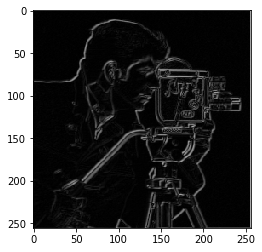

In [16]:
img = get_smple('./cman.jpg', True, True)

inp = np.array([img])
prediction = model.predict(inp)[0]
out = global_otsu_thresholding(prediction)
plt.imshow(prediction, cmap='gray')

#### The architecture of the netwoek is presented below

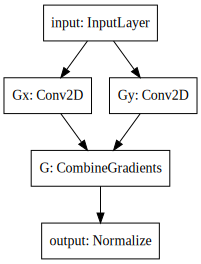

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### Let's see what the network has actually learned during the training process

The first thing we can notice is that `Gx` is not the transpose of `Gy` which was the case for all first order derivative based algorithms. Also neither `Gx` nor `Gy` are symmetric about central axis. Next thing we can notice is that the network learned that it doesn't need a bias term to detect edges as both bias terms for `Gx` and `Gy` are very close to 0.

So, we can see that in order to detect edges one doesn't need to work with derivatives or try to approximate any of the existing operators like Sobel's, Prewitt's, or Robert's.

In [13]:
Gx = model.layers[1]
Gy = model.layers[2]

filterX = np.reshape(Gx.get_weights()[0], newshape=(3, 3))
filterY = np.reshape(Gy.get_weights()[0], newshape=(3, 3))
print('Filter in X direction (Gx):\n', filterX)
print('\nFilter in Y direction (Gy):\n', filterY)
print()
print('Bias for Gx:', Gx.get_weights()[1][0])
print('Bias for Gy:', Gy.get_weights()[1][0])

Filter in X direction (Gx):
 [[-0.03900059 -0.24562082 -0.19892806]
 [-0.22675623  0.07740413  0.61262661]
 [-0.07595865 -0.03728469  0.12737863]]

Filter in Y direction (Gy):
 [[ -5.40832102e-01  -4.37325686e-01   4.53617722e-02]
 [  3.44081074e-01   4.15887684e-01   4.16389972e-01]
 [  1.56539813e-01  -4.10680056e-01   1.84701319e-04]]

Bias for Gx: 0.000524893
Bias for Gy: 0.00834314


### Evaluation on testing dataset

We evaluate the network on testing dataset using MSE (mean squared error)

In [14]:
def evaluate(inputs, labels, apply_thresholding=None):
    predictions = model.predict(inputs)
    
    if apply_thresholding:
        predictions = [apply_thresholding(prediction) for prediction in predictions]
    
    labels = np.array(labels) * 255.
    predictions = np.array(predictions) * 255.
    return ((labels - predictions) ** 2).mean(axis=None)

In [15]:
print('Neural Network without thresholding:', evaluate(test_input, test_label))
print('Neural Network with otsu thresholding:', evaluate(test_input, test_label, global_otsu_thresholding))

Neural Network without thresholding: 1184.28
Neural Network with otsu thresholding: 6959.74126808
